In [1]:
# For classic ML models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [4]:
# Load the dataset
data = pd.read_csv('...\data_cleaned.csv')

corr = data.corr()
strong_correlation_cols = [col for col in corr.columns if corr.loc['HadHeartAttack', col] >= 0.1 and col != 'HadHeartAttack']

# Select features (X) and target (y)
X = data[strong_correlation_cols]
y = data['HadHeartAttack']

strong_correlation_cols
# Select features (X) and target (y)
X = data[strong_correlation_cols]
y = data['HadHeartAttack']

strong_correlation_cols

for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Warning: Column {col} is still of type 'object'. Attempting to convert.")
    data[col] = data[col].astype('int', errors='ignore')

X = data[strong_correlation_cols]
y = data['HadHeartAttack'].astype('int')

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from imblearn.over_sampling import SMOTE

resampler = SMOTE()
X_train, y_train = resampler.fit_resample(X_train, y_train)

print("train set features shape:", X_train.shape)
print("test set features shape:", X_test.shape)
print("train set objective shape:", y_train.shape)
print("test set objective shape:", y_test.shape)

train set features shape: (372040, 11)
test set features shape: (49203, 11)
train set objective shape: (372040,)
test set objective shape: (49203,)


In [14]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

def evaluate_model(model, X_test, y_test, model_name):
    # 预测结果
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # 生成混淆矩阵和分类报告
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, zero_division=1)

    # 输出结果
    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Classification Report:\n{class_report}')

    # 输出混淆矩阵
    print('Confusion Matrix:')
    print(conf_matrix)

    # ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # 计算 ROC 曲线数据
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"{model_name} ROC AUC: {roc_auc:.2f}")

    return accuracy
def plot_pr_curve(model, X_test, y_test, model_name):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)

    precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

    # 计算并显示 PR AUC
    pr_auc = auc(recall, precision)
    print(f"{model_name} PR AUC: {pr_auc:.2f}")

    # 绘制 PR 曲线
    plt.figure()
    plt.step(recall, precision, where='post', color='b', alpha=0.2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for {model_name}')
    plt.legend(loc="lower left")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.show()


Gradient Boosting Results:
Gradient Boosting Classifier Accuracy: 0.79
Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     46558
           1       0.17      0.76      0.28      2645

    accuracy                           0.79     49203
   macro avg       0.58      0.78      0.58     49203
weighted avg       0.94      0.79      0.84     49203

Confusion Matrix:
[[36824  9734]
 [  623  2022]]
Gradient Boosting Classifier ROC AUC: 0.87
Gradient Boosting PR AUC: 0.36


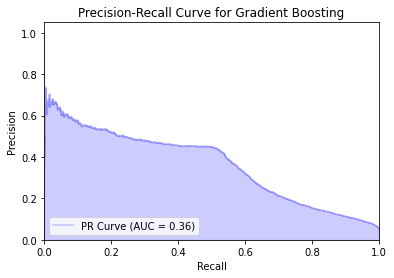

In [15]:
#GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
print("Gradient Boosting Results:")
gbc_accuracy = evaluate_model(gbc, X_test, y_test, 'Gradient Boosting Classifier')
plot_pr_curve(gbc, X_test, y_test, "Gradient Boosting")

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [01:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier Accuracy: 0.81
XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     46558
           1       0.18      0.71      0.29      2645

    accuracy                           0.81     49203
   macro avg       0.58      0.76      0.59     49203
weighted avg       0.94      0.81      0.86     49203

Confusion Matrix:
[[37890  8668]
 [  760  1885]]
XGBoost Classifier ROC AUC: 0.85
XGBoost PR AUC: 0.34


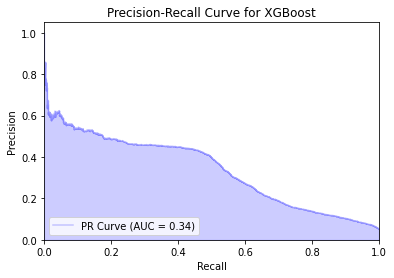

In [16]:
# XGBoost
import xgboost as xgb
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgboost_model.fit(X_train, y_train)

xgboost_accuracy = evaluate_model(xgboost_model, X_test, y_test, 'XGBoost Classifier')
plot_pr_curve(xgboost_model, X_test, y_test, "XGBoost")

In [17]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

param_dist = {
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 64, 128, 256],
    'max_depth': [5, 10, 15, 20],
    'min_data_in_leaf': [10, 50, 100, 200],
    'bagging_fraction': [0.5, 0.7, 0.9],
    'feature_fraction': [0.5, 0.7, 0.9],
    'reg_alpha': [0.1, 0.5, 1, 5],
    'reg_lambda': [0.1, 0.5, 1, 5]
}

model = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, scoring='accuracy', cv=5, random_state=42)
random_search.fit(X_train, y_train)

print("最佳参数:", random_search.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 148816, number of negative: 148816
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can se

In [ ]:
{'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 256, 'min_data_in_leaf': 50, 'max_depth': 15, 'learning_rate': 0.05, 'feature_fraction': 0.7, 'bagging_fraction': 0.9}

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
LightGBM Classifier Accuracy: 0.81
LightGBM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89     46558
           1       0.18      0.73      0.29      2645

    accuracy                           0.81     49203
   macro avg       0.58      0.77      0.59     49203
weighted avg       0.94      0.81      0.86     49203

Confusion Matrix:
[[37804  8754]
 [  724  1921]]
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_b

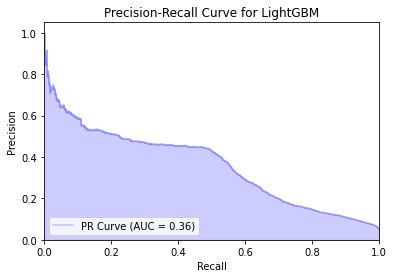

In [19]:
lightgbm_accuracy = evaluate_model(random_search, X_test, y_test, 'LightGBM Classifier')
plot_pr_curve(random_search, X_test, y_test, "LightGBM")

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(model, X_test, y_test, model_name="Model"):
    ns_probs = [0 for _ in range(len(y_test))]
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    ns_auc = roc_auc_score(y_test, ns_probs)
    
    # 模型的预测概率
    if hasattr(model, "predict_proba"):  # 如果模型有 predict_proba 方法
        y_probs = model.predict_proba(X_test)[:, 1]  # 获取正类概率
    else:
        y_probs = model.decision_function(X_test)  # 如果没有 predict_proba，尝试 decision_function

    # 计算模型的 ROC 和 AUC
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = roc_auc_score(y_test, y_probs)

    # 打印 AUC
    print(f"No Skill: ROC AUC = {ns_auc:.3f}")
    print(f"{model_name}: ROC AUC = {auc_score:.3f}")
    
    # 绘制 ROC 曲线
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill")
    plt.plot(fpr, tpr, marker=".", label=f"{model_name} (AUC = {auc_score:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid()
    plt.show()

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
No Skill: ROC AUC = 0.500
LightGBM: ROC AUC = 0.862


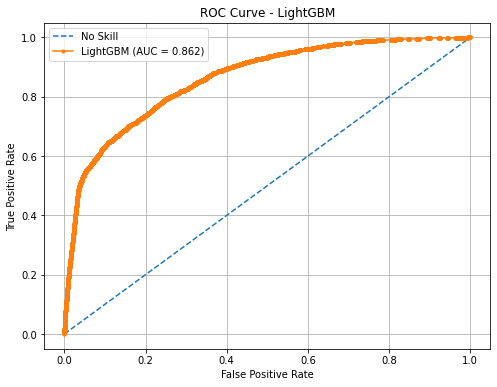

In [25]:
plot_roc_curve(random_search, X_test, y_test, "LightGBM")

No Skill: ROC AUC = 0.500
Gradient Boosting: ROC AUC = 0.870


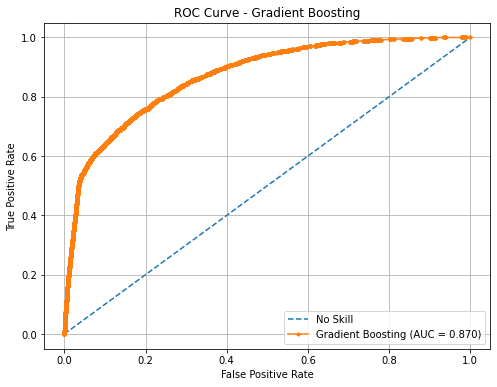

In [26]:
plot_roc_curve(gbc, X_test, y_test, "Gradient Boosting")

No Skill: ROC AUC = 0.500
XGBoost: ROC AUC = 0.851


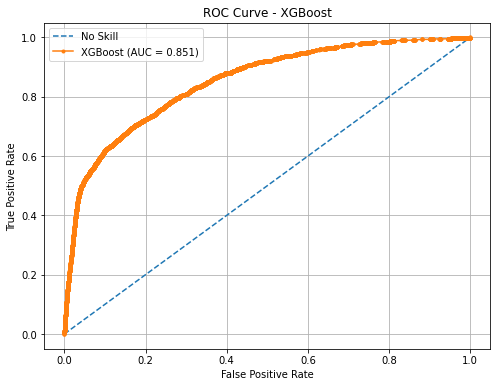

In [32]:
plot_roc_curve(xgboost_model, X_test, y_test, "XGBoost")

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 定义超参数范围
param_dist2 = {
    'n_estimators': [50, 100, 150, 200, 300],  # 树的数量
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],  # 学习率
    'max_depth': [3, 5, 10, 15],  # 树的最大深度
    'min_samples_split': [2, 5, 10],  # 分割节点时的最小样本数
    'min_samples_leaf': [1, 2, 4],  # 叶节点的最小样本数
    'subsample': [0.8, 0.9, 1.0],  # 用于每棵树的训练样本比例
    'max_features': ['auto', 'sqrt', 'log2']  # 每棵树的最大特征数
}

# 创建 Gradient Boosting 分类器
gbc = GradientBoostingClassifier(random_state=42)

# 使用 RandomizedSearchCV 调整超参数
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist2, n_iter=20, scoring='accuracy', cv=5, random_state=42)
random_search.fit(X_train, y_train)

# 输出最佳超参数
print("最佳超参数:", random_search.best_params_)

# 使用优化后的模型进行评估
optimized_gbc = random_search.best_estimator_

# 评估优化后的模型
gbc_accuracy = evaluate_model(optimized_gbc, X_test, y_test, 'Optimized Gradient Boosting Classifier')

# 绘制 PR 曲线
plot_pr_curve(optimized_gbc, X_test, y_test, "Optimized Gradient Boosting")

# 绘制 ROC 曲线
plot_roc_curve(optimized_gbc, X_test, y_test, "Optimized Gradient Boosting")

KeyboardInterrupt: 

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [03:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


最佳超参数: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Optimized XGBoost Classifier Accuracy: 0.83
Optimized XGBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     46558
           1       0.18      0.61      0.27      2645

    accuracy                           0.83     49203
   macro avg       0.58      0.72      0.59     49203
weighted avg       0.93      0.83      0.87     49203

Confusion Matrix:
[[39057  7501]
 [ 1034  1611]]
Optimized XGBoost Classifier ROC AUC: 0.80
Optimized XGBoost PR AUC: 0.29


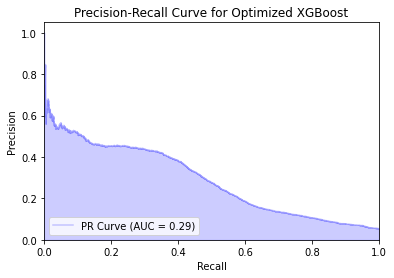

No Skill: ROC AUC = 0.500
Optimized XGBoost: ROC AUC = 0.800


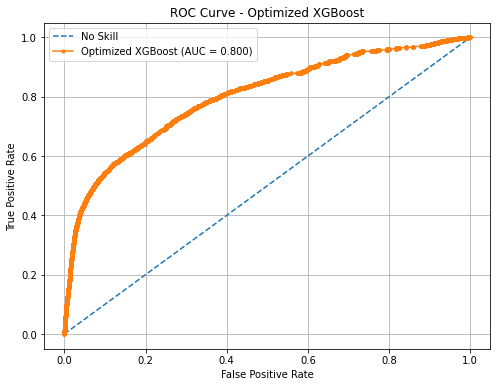

In [34]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# 定义超参数范围
param_dist3 = {
    'n_estimators': [50, 100, 150, 200, 300],  # 树的数量
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 学习率
    'max_depth': [3, 5, 7, 10],  # 树的最大深度
    'min_child_weight': [1, 2, 5, 10],  # 最小子节点权重
    'subsample': [0.7, 0.8, 0.9, 1.0],  # 训练样本的子采样比例
    'colsample_bytree': [0.7, 0.8, 1.0],  # 每棵树的特征子采样比例
    'gamma': [0, 0.1, 0.2, 0.5],  # 正则化项，用于控制模型的复杂度
    'reg_alpha': [0, 0.1, 0.5, 1],  # L1正则化项
    'reg_lambda': [0.1, 0.5, 1],  # L2正则化项
}

# 创建 XGBoost 分类器
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 使用 RandomizedSearchCV 调整超参数
random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=param_dist3, n_iter=20, scoring='accuracy', cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# 输出最佳超参数
print("最佳超参数:", random_search.best_params_)

# 使用优化后的模型
optimized_xgboost = random_search.best_estimator_

# 评估优化后的模型
xgboost_accuracy = evaluate_model(optimized_xgboost, X_test, y_test, 'Optimized XGBoost Classifier')

# 绘制 PR 曲线
plot_pr_curve(optimized_xgboost, X_test, y_test, "Optimized XGBoost")

# 绘制 ROC 曲线
plot_roc_curve(optimized_xgboost, X_test, y_test, "Optimized XGBoost")